<a href="https://colab.research.google.com/github/bratzaharia/ml-data-science-1/blob/main/MiniProiect_Regresie_bratc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 🧩 Mini-Proiect: Regresie și Îmbunătățire de Model



In [1]:
# 🔹 1️⃣ Alegeți un dataset
# Breast cancer => url "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"

# ✏️ Ce dataset ați ales și de ce?
# Răspuns: Am ales un set de date medicale: biopsii. Intrebarea dupa ce am vizualizat coloanele este
# dacă am valorile pentru un nodul nou (grosime, uniformitate, mitoze etc.), care e probabilitatea să fie malign (cancer) sau benign?
# ultima coloana contine clasa = variabila target.


In [2]:
# Verificați datele =>
# Sunt inconsistențe în date pe care ar trebui sa le tratăm?
# Sunt outlieri?
# Realizați cel puțin 2 vizualizări pe datele pe care plănuim să le folosim ca să observăm forma lor

In [3]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import copy


pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 20)

# URL către datasetul pinguini (CSV public)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"

# Citim CSV-ul într-un DataFrame (tabel Pandas)
columns = [
    # "Sample code number", # id-ul probei
    "Clump Thickness", # grosime grup celule => malign tinde spre gros/ aglomerat; val 1 - subtire 10 gros
    "Uniformity of Cell Size", # uniformitate dimensiune cell 1 - la fel 10 dimensiuni dif, anormale => malign dim haotice, deci scor mare
    "Uniformity of Cell Shape", # uniform formei celula 1 = cam la fel 10 forme ff dif, => malign = uratenia/variabilitatea formei
    "Marginal Adhesion", # aderenta margine cel, cat de bine stau lipite => malign pierde adeziunea, scor mare == mai suspect
    "Single Epithelial Cell Size", # dim unei sg celule epiteliale => daca sunt mari probabil malign, 1 normal - 10 foarte mare
    "Bare Nuclei", # nuclee goale, fara cito clara in jur, feature important! => 1 - 10 => val mare corelat cu malignitatea
    "Bland Chromatin", # cromatina uniforma, 1 normala - 10 foarte atipica, cromatina arata modul cum e impachetat ADN-ul in nucleu, aspect schimbat la celule maligne
    "Normal Nucleoli", # nocleol normal => 1 cca. niciun nucleol anormal 10 multi si anormali => 10 asociat cu malign
    "Mitoses", # mitoze = nr de celule in diviziune 1 putine 10 multe => cel malign se divid des! scor mare!
    "Class" # var target 2 = benign - nodul necanceros 4 malign = va fi in ML 0/1
]

df_raw = pd.read_csv(url, header=None, names=columns)

# Vizualizăm primele 5 rânduri (sanity check)
df_raw.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
1000025,5,1,1,1,2,1,3,1,1,2
1002945,5,4,4,5,7,10,3,2,1,2
1015425,3,1,1,1,2,2,3,1,1,2
1016277,6,8,8,1,3,4,3,7,1,2
1017023,4,1,1,3,2,1,3,1,1,2


In [4]:
# diagnoza initiala, ne uitam la forme, tipuri de date, lipsuri si distributii rapide
print("(linii, coloane):", df_raw.shape)
df_raw.info()

(linii, coloane): (699, 10)
<class 'pandas.core.frame.DataFrame'>
Index: 699 entries, 1000025 to 897471
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Clump Thickness              699 non-null    int64 
 1   Uniformity of Cell Size      699 non-null    int64 
 2   Uniformity of Cell Shape     699 non-null    int64 
 3   Marginal Adhesion            699 non-null    int64 
 4   Single Epithelial Cell Size  699 non-null    int64 
 5   Bare Nuclei                  699 non-null    object
 6   Bland Chromatin              699 non-null    int64 
 7   Normal Nucleoli              699 non-null    int64 
 8   Mitoses                      699 non-null    int64 
 9   Class                        699 non-null    int64 
dtypes: int64(9), object(1)
memory usage: 60.1+ KB


In [5]:
df_raw.describe()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bland Chromatin,Normal Nucleoli,Mitoses,Class
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [6]:
# verificare duplicate
df_raw.duplicated().sum()
# df_raw[df_raw.duplicated()].head(10)

np.int64(236)

In [7]:
# verifi daca in col numerice exista nr negative
num_cols = df_raw.select_dtypes(include='number').columns
(df_raw[num_cols] < 0).sum()

,0
Clump Thickness,0
Uniformity of Cell Size,0
Uniformity of Cell Shape,0
Marginal Adhesion,0
Single Epithelial Cell Size,0
Bland Chromatin,0
Normal Nucleoli,0
Mitoses,0
Class,0


In [8]:
# Verificat valori null
df_raw.isnull().sum().value_counts(dropna=False)

,count
0,10


In [9]:
# verificare daca exista null in coloane?
# procent de lipsuri
missing_percent = df_raw.isnull().mean() * 100

print("\nProcent valori lipsă (%):")
print(missing_percent.sort_values(ascending=False))


Procent valori lipsă (%):
Clump Thickness                0.0
Uniformity of Cell Size        0.0
Uniformity of Cell Shape       0.0
Marginal Adhesion              0.0
Single Epithelial Cell Size    0.0
Bare Nuclei                    0.0
Bland Chromatin                0.0
Normal Nucleoli                0.0
Mitoses                        0.0
Class                          0.0
dtype: float64


In [10]:
# Elimina duplicatele:
df_raw = df_raw.drop_duplicates(keep='first')
# df_raw.head(10)
df_raw.duplicated().sum()

np.int64(0)

In [11]:
df_raw[df_raw.isnull().any(axis=1)]

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class


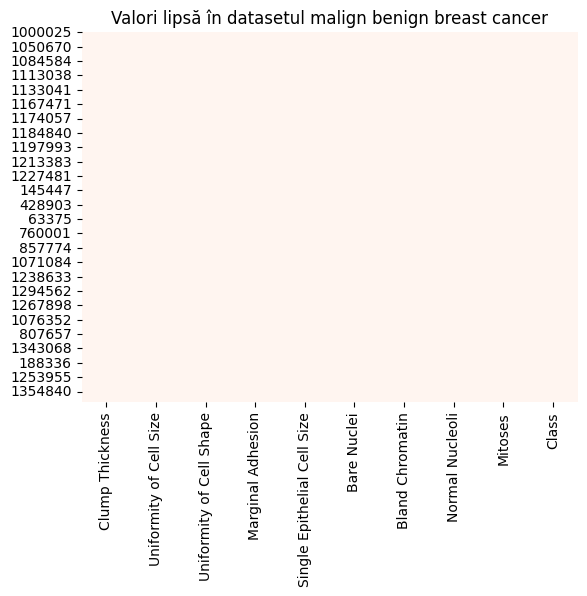

In [12]:
# heatmap va setul de date
# valori lipsa
sns.heatmap(df_raw.isnull(), cbar=False, cmap="Reds")
plt.title("Valori lipsă în datasetul malign benign breast cancer")
plt.show()

In [13]:
# transform Bare Nuclei from obj => number
# df_raw["Bare Nuclei"].isna().sum()
# df_raw["Bare Nuclei"].dtype
# df_raw["Bare Nuclei"].map(type).unique()
df_raw["Bare Nuclei"].unique()


# curatare Bare Nuclei = e string => number
df_raw["Bare Nuclei"] = df_raw["Bare Nuclei"].astype(str).str.strip() # delete spaces
df_raw["Bare Nuclei"] = df_raw["Bare Nuclei"].replace("?", np.nan)
df_raw["Bare Nuclei"] = df_raw["Bare Nuclei"].astype(float)
df_raw["Bare Nuclei"].unique()

print(df_raw["Bare Nuclei"].unique())
print(df_raw["Bare Nuclei"].isna().sum())

[ 1. 10.  2.  4.  3.  9.  7. nan  5.  8.  6.]
14


In [14]:
#  Tratare lipsuri
# x → imputăm cu mediană (robust la outlieri)

median_bn = df_raw["Bare Nuclei"].median()
df_raw["Bare Nuclei"] = df_raw["Bare Nuclei"].fillna(median_bn)

print(df_raw["Bare Nuclei"].isna().sum())
print(df_raw["Bare Nuclei"].unique())



0
[ 1. 10.  2.  4.  3.  9.  7.  5.  8.  6.]


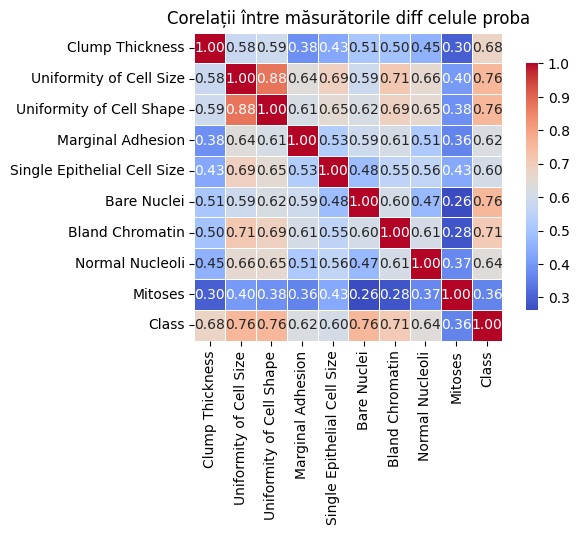

In [15]:
# plot sa vad corelatiile > pt model raman doar feature cu > 0.3
columns = [
    # "Sample code number", # id-ul probei
    "Clump Thickness", # grosime grup celule => malign tinde spre gros/ aglomerat; val 1 - subtire 10 gros
    "Uniformity of Cell Size", # uniformitate dimensiune cell 1 - la fel 10 dimensiuni dif, anormale => malign dim haotice, deci scor mare
    "Uniformity of Cell Shape", # uniform formei celula 1 = cam la fel 10 forme ff dif, => malign = uratenia/variabilitatea formei
    "Marginal Adhesion", # aderenta margine cel, cat de bine stau lipite => malign pierde adeziunea, scor mare == mai suspect
    "Single Epithelial Cell Size", # dim unei sg celule epiteliale => daca sunt mari probabil malign, 1 normal - 10 foarte mare
    "Bare Nuclei", # nuclee goale, fara cito clara in jur, feature important! => 1 - 10 => val mare corelat cu malignitatea
    "Bland Chromatin", # cromatina uniforma, 1 normala - 10 foarte atipica, cromatina arata modul cum e impachetat ADN-ul in nucleu, aspect schimbat la celule maligne
    "Normal Nucleoli", # nocleol normal => 1 cca. niciun nucleol anormal 10 multi si anormali => 10 asociat cu malign
    "Mitoses", # mitoze = nr de celule in diviziune 1 putine 10 multe => cel malign se divid des! scor mare!
    "Class" # var target 2 = benign - nodul necanceros 4 malign = va fi in ML 0/1
]



corr = df_raw[columns].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(
    corr,
    annot=True,              # afișează valorile numerice
    cmap="coolwarm",         # paletă de culori (roșu-albastru)
    fmt=".2f",               # două zecimale
    linewidths=0.5,          # separatoare între celule
    square=True,
    cbar_kws={"shrink": 0.8} # bara laterală mai mică
)
plt.title("Corelații între măsurătorile diff celule proba")
plt.show()

In [16]:
# plot general
# df_raw[columns].hist(figsize=(10, 8), bins=10)
# plt.tight_layout()
# plt.show()

In [17]:
# subset = [
#     "Clump Thickness",
#     "Uniformity of Cell Size",
#     "Uniformity of Cell Shape",
#     "Bare Nuclei",
#     "Class",
# ]

# sns.pairplot(
#     df_raw[subset],
#     hue="Class",
#     diag_kind="hist",
#     corner=True,   # doar jumătate de matrice, ca să nu fie prea aglomerat
# )
# plt.show()

In [18]:
# df_melt = df_raw.melt(
#     id_vars="Class",
#     value_vars=columns,
#     var_name="Feature",
#     value_name="Value"
# )

# plt.figure(figsize=(10, 6))
# sns.boxplot(
#     data=df_melt,
#     x="Feature",
#     y="Value",
#     hue="Class"
# )
# plt.xticks(rotation=90)
# plt.tight_layout()
# plt.show()

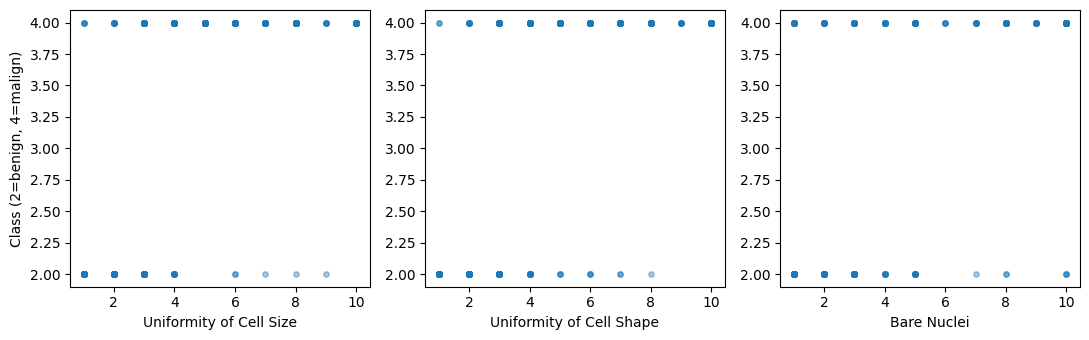

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(11, 3.5))

# 1) Uniformity of Cell Size vs Class
axs[0].scatter(
    df_raw["Uniformity of Cell Size"],
    df_raw["Class"],
    s=15,
    alpha=0.4
)
axs[0].set_xlabel("Uniformity of Cell Size")
axs[0].set_ylabel("Class (2=benign, 4=malign)")

# 2) Uniformity of Cell Shape vs Class
axs[1].scatter(
    df_raw["Uniformity of Cell Shape"],
    df_raw["Class"],
    s=15,
    alpha=0.4
)
axs[1].set_xlabel("Uniformity of Cell Shape")

# 3) Bare Nuclei vs Class
axs[2].scatter(
    df_raw["Bare Nuclei"],
    df_raw["Class"],
    s=15,
    alpha=0.4
)
axs[2].set_xlabel("Bare Nuclei")

plt.tight_layout()
plt.show()


In [20]:
# 🔹 2️⃣ Alegeți o variabilă țintă

# ✏️ Ce variabilă țintă ați ales?
# Răspuns: Class

# ✏️ De ce considerați că este o alegere potrivită?
# Răspuns: Este targetul nostru benign/malign => din datele pe care le avem sa putem construi un model care poate prezice clasa malign sau benign


In [21]:
# Cu ce date se corelează variabila țintă?
# cu toate in afara de mitoze, care are o valoare de corr de 0.32 => nu va intra in model!

In [43]:
# OLS cu 1 predictor pt exercitiu
# data x= 1 predictor
columns = [
    "Clump Thickness",
    "Uniformity of Cell Shape",
    "Marginal Adhesion", # aderenta margine cel, cat de bine stau lipite => malign pierde adeziunea, scor mare == mai suspect
    "Single Epithelial Cell Size", # dim unei sg celule epiteliale => daca sunt mari probabil malign, 1 normal - 10 foarte mare
    "Bare Nuclei", # nuclee goale, fara cito clara in jur, feature important! => 1 - 10 => val mare corelat cu malignitatea
    "Bland Chromatin", # cromatina uniforma, 1 normala - 10 foarte atipica, cromatina arata modul cum e impachetat ADN-ul in nucleu, aspect schimbat la celule maligne
    "Normal Nucleoli", # nocleol normal => 1 cca. niciun nucleol anormal 10 multi si anormali => 10 asociat cu malign
    "Mitoses", # mitoze = nr de celule in diviziune 1 putine 10 multe => cel malign se divid des! scor mare!
    "Class" # var target 2 = benign - nodul necanceros 4 malign = va fi in ML 0/1
]

df = df_raw[columns]
x = df["Bare Nuclei"]
y = df["Class"]
# print(x,y)

# calculeaza linia optima OLS
# m = np.sum((x - x.mean()) * (y - y.mean())) / np.sum((x - x.mean()) ** 2)
# n = y.mean() - m * x.mean()
# # print(f"m = {m}, n = {n}")

# y_pred_ols = m * x + n

# Plot
# plt.figure(figsize=(6, 4))
# plt.scatter(x, y, color="steelblue", alpha=0.2, label="Puncte reale")
# plt.axhline(2, color="gray", linestyle="--", alpha=0.5)
# plt.axhline(4, color="gray", linestyle="--", alpha=0.5)

# plt.plot(x, y_pred_ols, "-", color="green", linewidth=2, label=f"OLS: y = {m:.1f}x + {n:.1f}")

# plt.title("OLS: găsim linia cu eroarea totală cea mai mică")
# plt.xlabel("Uniformity of Cell Size")
# plt.ylabel("Class")
# plt.legend()
# plt.grid(True)
# plt.show()


In [55]:
# Verificăm că features există
# for col in ["Normal Nucleoli", "Bare Nuclei"]:
#     if col not in df.columns:
#         raise ValueError(f"Coloana necesară '{col}' lipsește din dataset.")

# features = ["Clump Thickness", "Uniformity of Cell Shape", "Marginal Adhesion", "Single Epithelial Cell Size"]
features = ["Clump Thickness", "Uniformity of Cell Shape", "Marginal Adhesion", "Single Epithelial Cell Size", "Normal Nucleoli", "Bare Nuclei"]
X = df[features].values
y = (df["Class"] == 4).astype(int).values  # 0/1, recomandat pentru clasificare


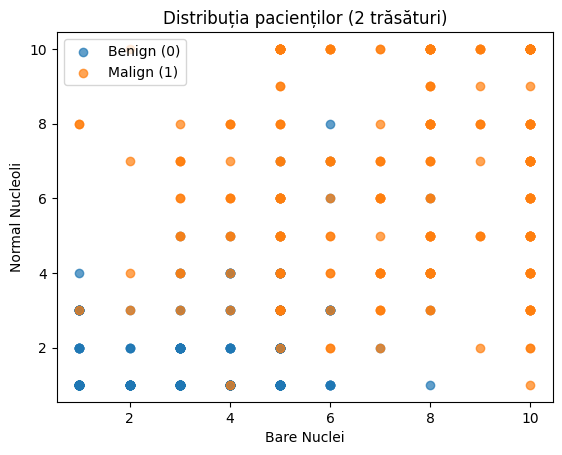

In [56]:
# Scatter simplu (doar matplotlib, fără seaborn)

plt.figure()
mask_m = (y == 1)
mask_b = (y == 0)
plt.scatter(X[mask_b, 0], X[mask_b, 1], label="Benign (0)", alpha=0.7)
plt.scatter(X[mask_m, 0], X[mask_m, 1], label="Malign (1)", alpha=0.7)
plt.xlabel("Bare Nuclei")
plt.ylabel("Normal Nucleoli")
plt.title("Distribuția pacienților (2 trăsături)")
plt.legend()
plt.show()

# add jitter (mai jos)


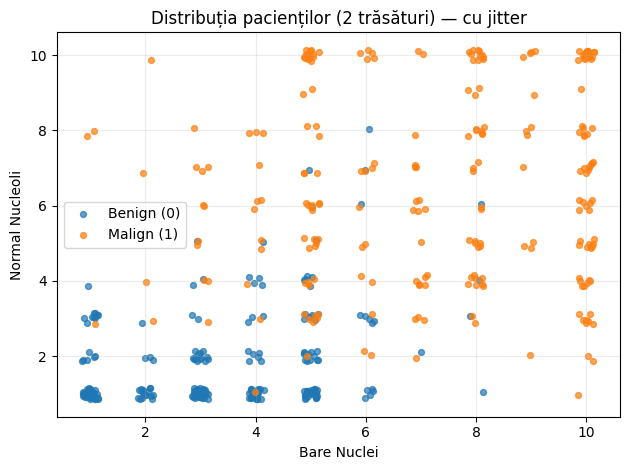

In [57]:
# cu jitter doar demo pt ca am datele suprapuse
plt.figure()

mask_m = (y == 1)
mask_b = (y == 0)

# jitter setări
rng = np.random.default_rng(42)  # reproducibil
eps = 0.15                       # mărimea jitter-ului (în jur de ±0.15)

# adăugăm jitter separat pe fiecare clasă (pe ambele axe)
bx = X[mask_b, 0] + rng.uniform(-eps, eps, size=mask_b.sum())
by = X[mask_b, 1] + rng.uniform(-eps, eps, size=mask_b.sum())

mx = X[mask_m, 0] + rng.uniform(-eps, eps, size=mask_m.sum())
my = X[mask_m, 1] + rng.uniform(-eps, eps, size=mask_m.sum())

# (opțional) dacă știi că valorile sunt pe scara 1–10, poți să le „tai” în interval
# bx = np.clip(bx, 1, 10); by = np.clip(by, 1, 10)
# mx = np.clip(mx, 1, 10); my = np.clip(my, 1, 10)

plt.scatter(bx, by, label="Benign (0)", alpha=0.7, s=18)
plt.scatter(mx, my, label="Malign (1)", alpha=0.7, s=18)

plt.xlabel("Bare Nuclei")
plt.ylabel("Normal Nucleoli")
plt.title("Distribuția pacienților (2 trăsături) — cu jitter")
plt.legend()
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

# 2) Split train/test + standardizare

In [58]:
# 🔹 3️⃣ Construiți un model inițial

# Tipuri posibile:
# - Linear Regression = am testat - e clar ca am nevoie de regresie logistica
# - Multiple Regression
# - Polynomial Regression
# - Logistic Regression

# ✏️ Ce tip de model ați ales?
# Răspuns: Aleg regresie logistica,

# ✏️ De ce ați ales acest tip de model?
# Răspuns: forma datelor e sigmoida, am nevoie de clasificare


# Notă - nu uitați să faceți split-ul pe date pe train / test!

In [59]:
# split train /test + standardizare
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, log_loss, confusion_matrix, roc_curve, auc
)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Dimensiuni:")
print("X_train:", X_train_scaled.shape, "X_test:", X_test_scaled.shape)

Dimensiuni:
X_train: (370, 6) X_test: (93, 6)





## 3) Model: Logistic Regression

In [60]:
# Regresie logistica
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

print("Acuratețe (train):", accuracy_score(y_train, model.predict(X_train_scaled)))
print("Acuratețe (test): ", accuracy_score(y_test, y_pred))
print("Log Loss (test): ", log_loss(y_test, y_proba))

print("\nIntercept:", model.intercept_)
print("Coeficienți (pentru features în ordinea {}):".format(features), model.coef_)

Acuratețe (train): 0.9486486486486486
Acuratețe (test):  0.946236559139785
Log Loss (test):  0.1623821704752907

Intercept: [0.74001585]
Coeficienți (pentru features în ordinea ['Clump Thickness', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Normal Nucleoli', 'Bare Nuclei']): [[1.48881901 1.07531503 0.6684855  0.60878164 0.55135043 1.64093107]]


In [61]:
# 🔹 4️⃣ Evaluați performanța modelului
from sklearn.metrics import mean_squared_error

# Calculați următoarele metrici:
# - RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_proba))
print("RMSE (pe probabilități) =", rmse)

# - R² (coeficientul de determinare) - nu se aplica

# ✏️ Care este valoarea RMSE obținută?
# Răspuns: 0.2262

# ✏️ Care este valoarea R² obținută?
# Răspuns: -

# ✏️ Cum interpretați aceste rezultate?
# Răspuns: RMSE e bun


RMSE (pe probabilități) = 0.21401950710244014


In [ ]:
#  confusion_matrix, roc_curve, auc
# accuracy score



In [30]:
# 🔹 5️⃣ Îmbunătățiți modelul


# Încercați una sau mai multe dintre:
# - Normalizare / Standardizare (cred ca datele au fost deja standardizate - dinpacate pt mine)
# - Regularizare (Ridge / Lasso)
# - Grad polinomial diferit
# - Schimbarea unor feature-uri # done! - cu cat am mai multe feature dovedite stiintific ca au leg cu aceasta anomalie creste acuratetea modelului

# ✏️ Ce modificări ați adus modelului?
# Răspuns: Am adaugat feature care "cantaresc" mai bine ca modelul sa invete

# ✏️ De ce ați ales aceste metode de îmbunătățire? teoretic
# Răspuns: am citit despre fiecare feature ce importanta are in evaluarea unui caz sau altul + datele au fost deja scalate etc si cumva m-a ajutat acest fapt


In [31]:
# 🔹 6️⃣ Comparați rezultatele (înainte vs după)


# ✏️ Care au fost valorile RMSE și R² înainte de îmbunătățire?
# Răspuns:

# ✏️ Care sunt valorile RMSE și R² după îmbunătățire?
# Răspuns:

# ✏️ Ce metodă a ajutat cel mai mult?
# Răspuns:

# ✏️ De ce credeți că acea metodă a fost eficientă?
# Răspuns:


In [32]:
# 🔹 💡 Concluzie finală


# ✏️ Ce ați învățat din acest experiment despre:
# - Alegerea tipului de model
# - Rolul normalizării / regularizării
# - Impactul metricilor în evaluarea performanței

# Răspuns:
